#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
theta1 = lambda x: np.cos(2*np.pi*3*x)*0.+2. #*np.sin(2*np.pi*3*x+.6)
theta2 = lambda x: np.sin(2*np.pi*3*x)*0.+2. #*np.sin(2*np.pi*3*x+.6)
con = lambda x: np.cos(2*np.pi*1*x)*0.5+0.5 #*np.sin(2*np.pi*3*x+.6)

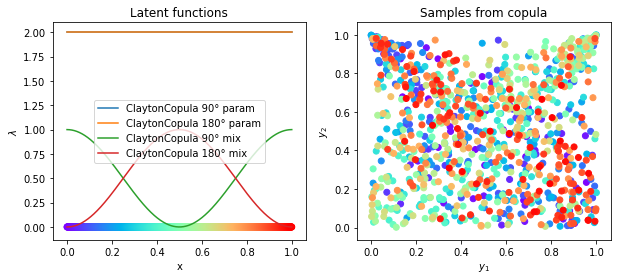

In [3]:
import matplotlib.cm as cm

#x_space setup
NSamp = int(1e3)
X = np.linspace(0.,1.,NSamp) 

# model setup
theta = torch.stack([torch.tensor([theta1(x) for x in X]),
                     torch.tensor([theta2(x) for x in X])]).float()
mix = torch.stack([torch.tensor([con(x) for x in X]),
                   torch.tensor([1-con(x) for x in X])]).float()
likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='90°'),
               bvcopula.ClaytonCopula_Likelihood(rotation='180°')]
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
copula_model = bvcopula.MixtureCopula(theta,mix,copulas,rotations=rotations)

#generate samples
Y = copula_model.sample().numpy().squeeze()
colors = cm.rainbow(np.linspace(0., 1., Y.shape[0]))

#plot model parameters and samples
fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

fp = utils.LatentSpacePlot('Latent functions','x','$\lambda$',lambdaf)
fp.plot(X,copula_model, colors=colors)

sp = utils.PlotSamples('Samples from copula','$y_1$','$y_2$',samples)
sp.plot(copula_model, Y, colors)

fig.show()

In [4]:
Y[(Y!=Y)==True]

array([], dtype=float32)

In [5]:
Y.max() <= 1-1e-3

False

In [6]:
Y.max() >= 1e-3

True

In [7]:
# formulate hypothesis
likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='180°'),
               bvcopula.ClaytonCopula_Likelihood(rotation='90°'),
              ]

In [8]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [9]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
model = bvcopula.Mixed_GPInferenceModel(bvcopula.MixtureCopula_Likelihood(likelihoods), 
                                        2*len(likelihoods)-1,
                                        prior_rbf_length=0.2, 
                                        grid_size=grid_size).cuda(device=0)

In [10]:
# train the model

base_lr = 1e-2
iter_print = 100
print('Basic lr for most of parameters: {}'.format(base_lr))

optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.parameters()},
    {'params': model.covar_module.parameters(), 'lr': .001}, #hyperparameters
], lr=base_lr)

mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)  
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p
            ))
            
            if (0 < mean_p < 0.001):
                print("Converged!")
                break
            p = 0.

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.116   lengthscale: [0.19762348 0.20357478 0.19812226], dLoss: 0.0
Iter 200/2000 - Loss: -0.229   lengthscale: [0.1936902  0.20839979 0.19222815], dLoss: 0.109
Iter 300/2000 - Loss: -0.257   lengthscale: [0.19280307 0.20800264 0.18476883], dLoss: 0.0281
Iter 400/2000 - Loss: -0.268   lengthscale: [0.19296974 0.21003936 0.17870536], dLoss: 0.00866
Iter 500/2000 - Loss: -0.273   lengthscale: [0.19488811 0.2153672  0.17480245], dLoss: 0.0037
Iter 600/2000 - Loss: -0.276   lengthscale: [0.19876696 0.22258517 0.17273067], dLoss: 0.00184
Iter 700/2000 - Loss: -0.277   lengthscale: [0.20387365 0.23041512 0.17193298], dLoss: 0.001
Iter 800/2000 - Loss: -0.278   lengthscale: [0.20939125 0.23811905 0.17193952], dLoss: 0.000598
Converged!
CPU times: user 22.7 s, sys: 229 ms, total: 22.9 s
Wall time: 22.9 s


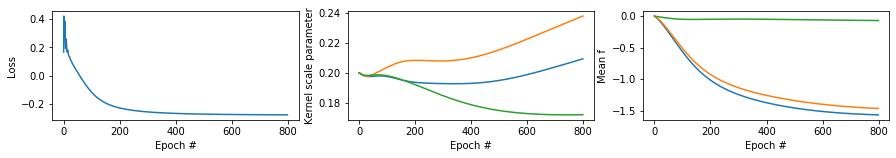

In [11]:
# prot loss function and kernel length
labels = ["Loss", "Kernel scale parameter", "Mean f"]
fig, ax = plt.subplots(1,3,figsize=(15,2))
plot = utils.PlotTraining(fig,ax,labels)#y_lims)
plot.plot([losses,rbf,[np.mean(x,axis=1) for x in means]])

In [12]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

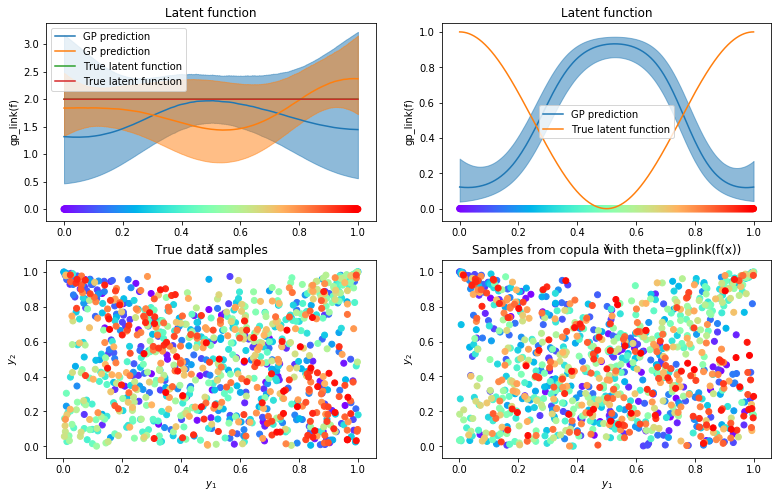

In [13]:
# visualize the result
fig, ax = plt.subplots(2,2,figsize=(13, 8))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)
 
for t,l,u in zip(thetas,thetas_low,thetas_upp):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,0].plot(testX, F_mean, label = 'GP prediction')
    ax[0,0].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,0].plot(testX,theta1(testX), label = 'True latent function')
ax[0,0].plot(testX,theta2(testX), label = 'True latent function')
ax[0,0].scatter(X,np.zeros_like(X),color=colors)
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('gp_link(f)')
ax[0,0].set_title('Latent function')
ax[0,0].legend()

for t,l,u in zip(mixes[:-1],mixes_low[:-1],mixes_upp[:-1]):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,1].plot(testX, F_mean, label = 'GP prediction')
    ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,1].plot(testX,con(testX), label = 'True latent function')
ax[0,1].scatter(X,np.zeros_like(X),color=colors)
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('gp_link(f)')
ax[0,1].set_title('Latent function')
ax[0,1].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
ax[1,1].scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for c in [0,1]:
    ax[1,c].set_xlabel('$y_1$')
    ax[1,c].set_ylabel('$y_2$')
ax[1,0].set_title('True data samples')
ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()

In [15]:
model.likelihood.WAIC(model(train_x), train_y)

tensor(292.0994, device='cuda:0')